In [2]:
import os
import json
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from torchvision import models, datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import StepLR
from torchvision.models import ResNet50_Weights
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

In [3]:
from torch.utils.data._utils.collate import default_collate

def collate_fn(batch):
    """
    Custom collation function for handling variable-sized target tensors.
    Each item in the batch is a dictionary with keys 'image', 'boxes', 'labels'.
    """
    # Extract images and targets from the batch
    images = [item['image'] for item in batch]
    targets = [{'boxes': item['boxes'], 'labels': item['labels']} for item in batch]

    # Use the default_collate to collate images
    images = default_collate(images)

    return images, targets

In [4]:
class ObjectDataset(Dataset):
    def __init__(self, csv_file, img_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        # Use the custom parser to read the CSV
        self.flags_frame = pd.read_csv(csv_file)
        
        self.img_dir = img_dir


    def __len__(self):
        return len(self.flags_frame)

    def __getitem__(self, idx):
        # Find all rows corresponding to the same image
        img_file_name = self.flags_frame.iloc[idx, 0]
        img_rows = self.flags_frame[self.flags_frame['filename'] == img_file_name]

        # Initialize lists for boxes and labels
        boxes = []
        labels = []

        # Load image
        img_name = os.path.join(self.img_dir, img_file_name)
        image = Image.open(img_name)

        # Iterate over all rows for this image
        for _, row in img_rows.iterrows():
            x, y, width, height = row['x'], row['y'], row['width'], row['height']
            box = self.parse_box_data(x, y, width, height)
            boxes.append(box)

            label_data = row['object_type']
            label = self.parse_label_data(label_data)
            labels.append(label)

        sample = {'image': image, 'boxes': boxes, 'labels': labels}

        if self.transform:
            sample = self.transform(sample)

        return sample

    @staticmethod
    def parse_box_data(x,y, width, height):
        # The box_data string needs to be cleaned up to be a valid JSON
        # Convert double double quotes to single double quotes
            
            
        # Convert to [xmin, ymin, xmax, ymax] format
        xmin = x
        ymin = y
        xmax = x + width
        ymax = y + height

        return [xmin, ymin, xmax, ymax]

    @staticmethod
    def parse_label_data(label_data):

        # Extract the object type
        object_type = label_data

        # Convert object types to numerical labels
        label_dict = {'flag': 1, 'map': 2}  # Label mapping here
        label = label_dict.get(object_type, 0)  # Default label 0 for unknown types

        return label

    @staticmethod
    def transform(sample):
        image, boxes, labels = sample['image'], sample['boxes'], sample['labels']
        original_size = image.size  # Original size of the image (W, H)
        
        # Resize image
        new_size = (448, 448)
        image = image.convert('RGB')
        image = F.resize(image, new_size)

        # Convert image to tensor
        image = F.to_tensor(image)

        # Adjust bounding boxes
        boxes = ObjectDataset.adjust_boxes(boxes, original_size, new_size)

        return {'image': image, 'boxes': torch.as_tensor(boxes, dtype=torch.float32), 'labels': torch.as_tensor(labels, dtype=torch.int64)}


    @staticmethod
    def adjust_boxes(boxes, original_size, new_size):
        #print(boxes)
        # Adjust the bounding box coordinates based on the new image size
        x_scale = new_size[0] / original_size[0]
        y_scale = new_size[1] / original_size[1]

        adjusted_boxes = []
        for box in boxes:
            xmin, ymin, xmax, ymax = box
            xmin = xmin * x_scale
            xmax = xmax * x_scale
            ymin = ymin * y_scale
            ymax = ymax * y_scale
            adjusted_boxes.append([xmin, ymin, xmax, ymax])

        return adjusted_boxes


In [21]:
class FlagDataset(Dataset):
    def __init__(self, csv_file, img_dir):
        self.data = []
        flags_frame = pd.read_csv(csv_file)
        flags_frame = flags_frame[(flags_frame["object_type"] == "flag") & (flags_frame["language"] != "not applicable")]

        for _, row in flags_frame.iterrows():
            img_file_name = row['filename']
            img_name = os.path.join(img_dir, img_file_name)
            image = Image.open(img_name)
            x, y, width, height = row['x'], row['y'], row['width'], row['height']
            cropped_image = self.crop_image(image, x, y, width, height)
            label_data = row['language']
            label = self.parse_label_data(label_data)
            self.data.append((cropped_image, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        cropped_image, label = self.data[idx]
        return self.transform(cropped_image), label

    @staticmethod
    def crop_image(image, x, y, width, height):
        return image.crop((x, y, x + width, y + height))

    @staticmethod
    def parse_label_data(label_data):
        label_dict = {'spanish': 1, 'french': 2, 'russian':3, 'swedish':4}  # Update as needed
        return label_dict.get(label_data, 0)

    @staticmethod
    def transform(image):
        # Apply transformations
        image = image.convert('RGB')
        image = F.resize(image, (112, 112))
        image = F.to_tensor(image)
        return image


In [22]:
# Initialize the flag dataset
flag_dataset = FlagDataset(csv_file='Labelling/flags_complete.csv',
                               img_dir='Images')

In [23]:
# Initialize the object dataset
object_dataset = ObjectDataset(csv_file='Labelling/flags_complete.csv',
                               img_dir='Images')

In [24]:
total_obj_size = len(object_dataset)
train_obj_size = int(0.8 * total_obj_size)
val_obj_size = total_obj_size - train_obj_size
# Adjust the train size to account for rounding
train_obj_size += total_obj_size - (train_obj_size + val_obj_size)

# Ensure random splits add up to the total size
assert train_obj_size + val_obj_size == total_obj_size

In [26]:
'''total_flag_size = len(flag_dataset)
train_flag_size = int(0.8 * total_flag_size)
test_flag_size = val_flag_size = int(0.1 * total_flag_size)
# Adjust the train size to account for rounding
train_flag_size += total_flag_size - (train_flag_size + test_flag_size + val_flag_size)

# Ensuren random splits add up to the total size
assert train_flag_size + test_flag_size + val_flag_size == total_flag_size'''

total_flag_size = len(flag_dataset)
train_flag_size = int(0.8 * total_flag_size)  # 80% of the dataset for training
val_flag_size = total_flag_size - train_flag_size  # The rest for validation

In [27]:
#train_flag_dataset, val_flag_dataset, test_flag_dataset = random_split(flag_dataset, [train_flag_size, val_flag_size, test_flag_size])

train_flag_dataset, val_flag_dataset = random_split(flag_dataset, [train_flag_size, val_flag_size])

In [28]:
train_object_dataset, val_object_dataset = random_split(object_dataset, [train_obj_size, val_obj_size])

In [29]:
print(len(flag_dataset))

611


In [30]:
batch_size = 16  # batch size

train_flag_loader = DataLoader(train_flag_dataset, batch_size=batch_size, shuffle=True)
val_flag_loader = DataLoader(val_flag_dataset, batch_size=batch_size, shuffle=False)
#test_flag_loader = DataLoader(test_flag_dataset, batch_size=batch_size, shuffle=False)

In [31]:
batch_size = 8  # batch size

train_loader = DataLoader(train_object_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_object_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
#test_loader = DataLoader(test_object_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

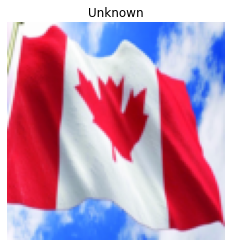

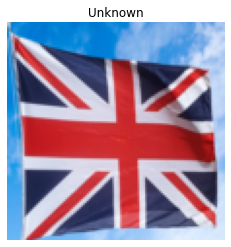

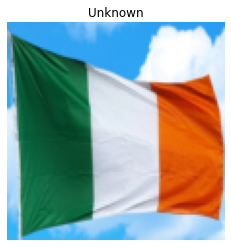

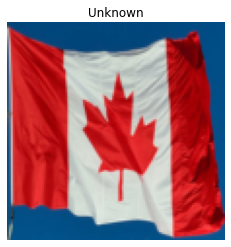

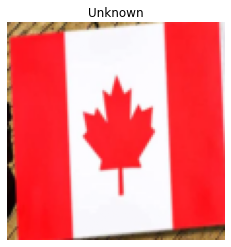

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def show_image_with_label(dataset, idx, label_map=None):
    image, label = dataset[idx]

    # Convert tensor image to numpy array
    if isinstance(image, torch.Tensor):
        np_image = image.cpu().numpy().transpose(1, 2, 0)
    else:
        np_image = np.array(image)

    # Normalize and display the image
    np_image = np_image - np_image.min()
    np_image = np_image / np_image.max()

    # Create a matplotlib figure
    fig, ax = plt.subplots()
    ax.imshow(np_image)

    # Display the label
    label_text = f'{label}' if label_map is None else label_map.get(label, 'Unknown')
    ax.set_title(label_text)
    ax.axis('off')  # Turn off axis

    plt.show()

# Label map
label_map = { 1: 'Spanish', 2: 'French', 3: "Russian", 4: "Swedish"}

# Preview first few images in the dataset
for i in range(5):
    show_image_with_label(flag_dataset, i, label_map)


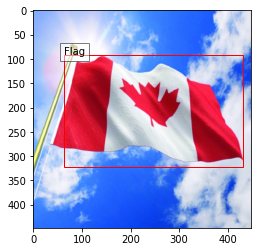

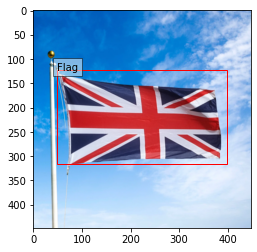

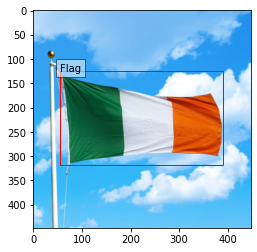

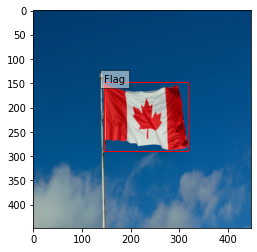

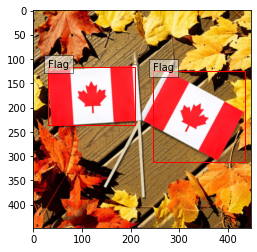

In [33]:
def show_image_with_boxes(dataset, idx, label_map=None):
    sample = dataset[idx]
    image, boxes, labels = sample['image'], sample['boxes'], sample['labels']

    if not isinstance(image, torch.Tensor):
        image = F.to_tensor(image)
    np_image = image.cpu().numpy().transpose(1, 2, 0)
    np_image = np_image - np_image.min()
    np_image = np_image / np_image.max()

    fig, ax = plt.subplots(1)
    ax.imshow(np_image)



    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        label_value = label.item()
        label_text = f'{label_value}' if label_map is None else label_map.get(label_value, 'Unknown')
        ax.text(xmin, ymin, label_text, bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

# Label map
label_map = {1: 'Flag', 2: 'Map'}

# Preview first few images in the dataset
for i in range(5):
    show_image_with_boxes(object_dataset, i, label_map)

In [34]:

device = torch.device("cpu")

In [35]:
# Object Detection Model
object_detection_model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

object_detection_model.to(device)
# Freeze certain layers for fine-tuning
for layer in object_detection_model.parameters():
    layer.requires_grad = False

# Modify the model for the desired number of classes (2 + background)
in_features = object_detection_model.roi_heads.box_predictor.cls_score.in_features
object_detection_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=3)


In [36]:
# Image Classification Model
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_classification_model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
image_classification_model.to(device)

# Freeze all layers except the last one
for param in image_classification_model.parameters():
    param.requires_grad = False
image_classification_model.fc.requires_grad = True

# Replace the pre-trained head with a new one
num_classes = 5  # Spanish, French, Russian and Swedish implemented in the dataset so far
image_classification_model.fc = nn.Linear(image_classification_model.fc.in_features, num_classes)

In [37]:

params = [p for p in object_detection_model.parameters() if p.requires_grad]
object_detection_model = object_detection_model.to(device)


optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 10
best_val_loss = float('inf')


for epoch in range(num_epochs):
    object_detection_model.train()
    train_loss = 0.0

    # Wrap train_loader with tqdm for a progress bar
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
    for images, targets in progress_bar:
        
        images = list(img.to(device) for img in images)

        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # Check device for each target tensor
        '''
        for target in targets:
            for key, value in target.items():
                if isinstance(value, torch.Tensor):
                    print(f"Target tensor '{key}' device:", value.device)
        '''

        optimizer.zero_grad()
        loss_dict = object_detection_model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        train_loss += losses.item()
        # Update progress bar with current loss
        progress_bar.set_postfix({'train_loss': losses.item()})

    # Validation phase
    object_detection_model.eval()  # Ensure the model is in eval mode for correct behavior
    val_loss = 0.0
    progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
    with torch.no_grad():
        for images, targets in progress_bar:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Temporarily set the model to training mode to compute the loss
            object_detection_model.train()
            loss_dict = object_detection_model(images, targets)
            object_detection_model.eval()  # Set it back to eval mode

            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
            # Update progress bar with current validation loss
            progress_bar.set_postfix({'val_loss': losses.item()})

    # Learning rate scheduler step
    scheduler.step()

    # Early stopping check
    if val_loss < best_val_loss:
        
        best_val_loss = val_loss
        # Save the best model
        torch.save(object_detection_model.state_dict(), 'best_object_detection_model.pth')

    print(f'Epoch {epoch}, Train Loss: {train_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}')


Epoch 1/10 [Validation]: 100%|██████████| 17/17 [04:37<00:00, 16.31s/it, val_loss=0.264]


Epoch 0, Train Loss: 0.4627700648201046, Val Loss: 0.3079092861974941


Epoch 2/10 [Validation]: 100%|██████████| 17/17 [04:01<00:00, 14.22s/it, val_loss=0.239]


Epoch 1, Train Loss: 0.31648605505921945, Val Loss: 0.2918541308711557


Epoch 3/10 [Validation]: 100%|██████████| 17/17 [03:59<00:00, 14.07s/it, val_loss=0.248]


Epoch 2, Train Loss: 0.30887071076613754, Val Loss: 0.28853196869878206


Epoch 4/10 [Validation]: 100%|██████████| 17/17 [04:05<00:00, 14.45s/it, val_loss=0.237]


Epoch 3, Train Loss: 0.2992643322517623, Val Loss: 0.2850935432840796


Epoch 5/10 [Validation]: 100%|██████████| 17/17 [04:36<00:00, 16.27s/it, val_loss=0.233]


Epoch 4, Train Loss: 0.2983332062835124, Val Loss: 0.2835489634205313


Epoch 6/10 [Validation]: 100%|██████████| 17/17 [04:02<00:00, 14.28s/it, val_loss=0.238]


Epoch 5, Train Loss: 0.2989777237621706, Val Loss: 0.2835393372704001


Epoch 7/10 [Validation]: 100%|██████████| 17/17 [04:43<00:00, 16.67s/it, val_loss=0.234]


Epoch 6, Train Loss: 0.296963507226154, Val Loss: 0.2815402088796391


Epoch 8/10 [Validation]: 100%|██████████| 17/17 [03:59<00:00, 14.08s/it, val_loss=0.231]


Epoch 7, Train Loss: 0.2977831919691456, Val Loss: 0.2829316810649984


Epoch 9/10 [Validation]: 100%|██████████| 17/17 [04:00<00:00, 14.17s/it, val_loss=0.236]


Epoch 8, Train Loss: 0.29779056337342336, Val Loss: 0.28246889570180106


Epoch 10/10 [Validation]: 100%|██████████| 17/17 [04:00<00:00, 14.13s/it, val_loss=0.229]


Epoch 9, Train Loss: 0.2977557469214966, Val Loss: 0.2812383972546634


In [38]:
from tqdm import tqdm

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_classification_model = image_classification_model.to(device)

# Define the optimizer and scheduler
optimizer = torch.optim.SGD(image_classification_model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
criterion = nn.CrossEntropyLoss()  # Using CrossEntropyLoss

num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    image_classification_model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_flag_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = image_classification_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    # Validation phase
    image_classification_model.eval()
    val_loss = 0.0
    progress_bar = tqdm(val_flag_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = image_classification_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            progress_bar.set_postfix({'val_loss': loss.item()})

    scheduler.step()

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(image_classification_model.state_dict(), 'best_image_classification_model.pth')

    print(f'Epoch {epoch}, Train Loss: {running_loss / len(train_flag_loader)}, Val Loss: {val_loss / len(val_flag_loader)}')

Epoch 1/10 [Validation]: 100%|██████████| 8/8 [00:02<00:00,  3.02it/s, val_loss=1.49]


Epoch 0, Train Loss: 1.5378091027659755, Val Loss: 1.4278423935174942


Epoch 2/10 [Validation]: 100%|██████████| 8/8 [00:02<00:00,  3.28it/s, val_loss=1.33]


Epoch 1, Train Loss: 1.3069937229156494, Val Loss: 1.2445130348205566


Epoch 3/10 [Validation]: 100%|██████████| 8/8 [00:02<00:00,  3.40it/s, val_loss=1.15]


Epoch 2, Train Loss: 1.1532241106033325, Val Loss: 1.1249812841415405


Epoch 4/10 [Validation]: 100%|██████████| 8/8 [00:02<00:00,  3.40it/s, val_loss=1.15] 


Epoch 3, Train Loss: 1.05129034673014, Val Loss: 1.1147941574454308


Epoch 5/10 [Validation]: 100%|██████████| 8/8 [00:02<00:00,  3.21it/s, val_loss=1.13]


Epoch 4, Train Loss: 1.0625690856287557, Val Loss: 1.1277342438697815


Epoch 6/10 [Validation]: 100%|██████████| 8/8 [00:02<00:00,  3.61it/s, val_loss=1.14]


Epoch 5, Train Loss: 1.0472504881120497, Val Loss: 1.1157850921154022


Epoch 7/10 [Validation]: 100%|██████████| 8/8 [00:02<00:00,  3.38it/s, val_loss=1.13]


Epoch 6, Train Loss: 1.011107160199073, Val Loss: 1.12736277282238


Epoch 8/10 [Validation]: 100%|██████████| 8/8 [00:02<00:00,  3.36it/s, val_loss=1.12] 


Epoch 7, Train Loss: 1.022796965414478, Val Loss: 1.0836955904960632


Epoch 9/10 [Validation]: 100%|██████████| 8/8 [00:02<00:00,  3.41it/s, val_loss=1.07] 


Epoch 8, Train Loss: 1.0191346964528483, Val Loss: 1.0710662603378296


Epoch 10/10 [Validation]: 100%|██████████| 8/8 [00:02<00:00,  3.40it/s, val_loss=1.12]

Epoch 9, Train Loss: 1.0011474586302234, Val Loss: 1.111492708325386


In [39]:
# Load fine-tuned object detection model
object_detection_model.load_state_dict(torch.load('best_object_detection_model.pth', map_location=torch.device('cpu')))
object_detection_model.to('cpu')
object_detection_model.eval()

# Load fine-tuned image classification model
image_classification_model.load_state_dict(torch.load('best_image_classification_model.pth', map_location=torch.device('cpu')))
image_classification_model.to('cpu')
image_classification_model.eval()


# Define transforms
transform = transforms.Compose([
    transforms.Resize((448, 448)),  # Resize the image
    transforms.ToTensor(),
    
])




In [52]:
# Load the image and apply transforms
image_path = "tester_pic2.jpg"  # Path to the image
image = Image.open(image_path)
if image.mode != 'RGB':
    image = image.convert('RGB')
image = transform(image)  # This will be a 3D tensor [C, H, W]
image = image.to(device)

# Detect objects in the image
object_detection_results = object_detection_model([image])  # Pass the image as a list

In [53]:
# Initialize lists for storing patches
flag_image_patches = []
map_image_patches = []

# Extract detection results
detected_boxes = object_detection_results[0]['boxes']
detected_labels = object_detection_results[0]['labels']
detected_scores = object_detection_results[0]['scores']

# Threshold for detection confidence
detection_threshold = 0.8

# Iterate over each detection
for i, box in enumerate(detected_boxes):
    if detected_scores[i] > detection_threshold:
        # Extract bounding box coordinates
        xmin, ymin, xmax, ymax = map(int, box.tolist())

        # Extract image patch based on the bounding box
        image_patch = image[:, ymin:ymax, xmin:xmax].unsqueeze(0)

        # Check label and append to corresponding list
        if detected_labels[i] == 1:  # Label 1 corresponds to 'flag'
            flag_image_patches.append(image_patch)
        elif detected_labels[i] == 2:  # Label 2 corresponds to 'map'
            map_image_patches.append(image_patch)



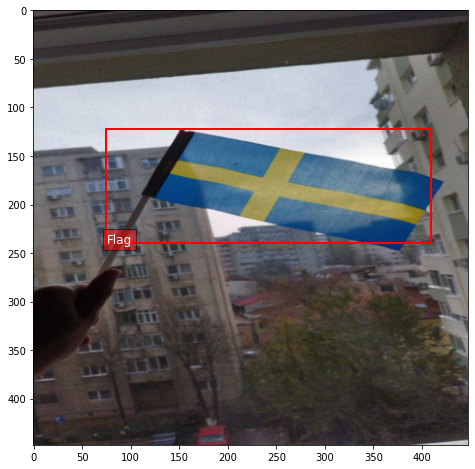

In [54]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Convert the tensor image back to PIL for visualization
np_image = image.cpu().squeeze(0).numpy()
np_image = np.transpose(np_image, (1, 2, 0))  # Change channel order for matplotlib
np_image = np_image - np_image.min()  # Normalize for display
np_image = np_image / np_image.max()

# Create a matplotlib figure
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(np_image)

# Add bounding boxes to the image
for i, box in enumerate(detected_boxes):
    if detected_scores[i] > detection_threshold:
        xmin, ymin, xmax, ymax = map(int, box.tolist())
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Add label text
        label = detected_labels[i].item()
        label_text = 'Flag' if label == 1 else 'Map' if label == 2 else 'Unknown'
        ax.text(xmin, ymax, label_text, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

plt.show()


In [55]:

import torch.nn.functional as F

# Classify each flag image patch and get probabilities for all predictions
flag_probabilities = []
for flag_image_patch in flag_image_patches:
    flag_image_patch = flag_image_patch.to(device)

    # Get model predictions (raw scores)
    with torch.no_grad():
        flag_outputs = image_classification_model(flag_image_patch)

    # Apply softmax to convert raw scores to probabilities
    probabilities = F.softmax(flag_outputs, dim=1)

    # Convert probabilities to numpy for easy manipulation
    probabilities_np = probabilities.cpu().numpy()

    # Append the probabilities to the flag_probabilities list
    flag_probabilities.append(probabilities_np)

    # Print the probabilities for each class
    print(probabilities_np)




[[0.21111016 0.12993932 0.18668526 0.19366011 0.27860516]]


In [58]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def visualize_detection_and_classification(image, detected_boxes, detected_scores, detected_labels, classification_probabilities, detection_threshold=0.8, label_map=None):
    # Convert tensor image to numpy array for display
    np_image = image.cpu().squeeze(0).numpy().transpose(1, 2, 0)
    np_image = np_image - np_image.min()
    np_image = np_image / np_image.max()

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(np_image)

    for i, box in enumerate(detected_boxes):
        if detected_scores[i] > detection_threshold:
            xmin, ymin, xmax, ymax = map(int, box.tolist())
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            detection_label = detected_labels[i].item()
            detection_label_text = 'Flag' if detection_label == 1 else 'Map' if detection_label == 2 else 'Unknown'
            
            # Get classification label with highest probability
            classification_prob = classification_probabilities[i][0]  # One flag per image patch
            print(classification_prob)
            classification_label = np.argmax(classification_prob)
            print(classification_label)

            if classification_label == 4:
                classification_label_text = "Swedish"
            if classification_label == 3:
                classification_label_text = "Russian"
            if classification_label == 2:
                classification_label_text = "French"
            if classification_label == 1:
                classification_label_text = "Spanish"
            else:
                classification_label_text = "Unknown"
            #classification_label_text = label_map.get(classification_label, 'Unknown')

            combined_label_text = f'{detection_label_text} | {classification_label_text} ({classification_prob[classification_label]:.2f})'
            ax.text(xmin, ymax, combined_label_text, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()


[0.21111016 0.12993932 0.18668526 0.19366011 0.27860516]
4


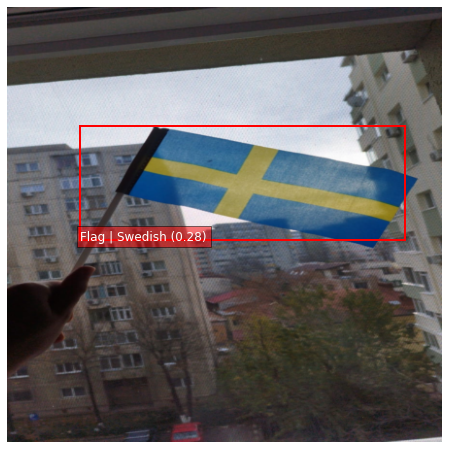

In [59]:
visualize_detection_and_classification(image, detected_boxes, detected_scores, detected_labels, flag_probabilities, label_map=label_map)
